<a href="https://colab.research.google.com/github/andrei-radulescu-banu/stat453-deep-learning-ss21/blob/main/L14/5-transfer-learning-mobilenet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install watermark
!git clone https://github.com/andrei-radulescu-banu/stat453-deep-learning-ss21.git
import sys, os
sys.path.append("/content/stat453-deep-learning-ss21/L14")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.8 MB/s 
Cloning into 'stat453-deep-learning-ss21'...
remote: Enumerating objects: 1255, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 1255 (delta 132), reused 4 (delta 4), pack-reused 1050
Receiving objects: 100% (1255/1255), 116.51 MiB | 26.71 MiB/s, done.
Resolving deltas: 100% (236/236), done.


STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

torch: 1.12.1+cu113



# Transferlearning -- MobileNet v3 on Cifar-10

## Imports

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [6]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [8]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),                 
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 224, 224])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


## Load Pre-Trained Model

In [9]:
model = torchvision.models.mobilenet_v3_large(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Freezing the Model

In [10]:
for param in model.parameters():
    param.requires_grad = False

Assume we want to fine-tune (train) the last 3 layers:

In [11]:
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

For the last layer, because the number of class labels differs compared to ImageNet, we replace the output layer with your own output layer:

In [12]:
model.classifier[3] = torch.nn.Linear(1280, 10)

## Then, Training as Usual

In [ ]:
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

Epoch: 001/050 | Batch 0000/0175 | Loss: 2.3125
Epoch: 001/050 | Batch 0100/0175 | Loss: 0.7156
Epoch: 001/050 | Train: 76.15% | Validation: 75.58%
Time elapsed: 3.64 min
Epoch: 002/050 | Batch 0000/0175 | Loss: 0.6891
Epoch: 002/050 | Batch 0100/0175 | Loss: 0.5901
Epoch: 002/050 | Train: 81.91% | Validation: 81.70%
Time elapsed: 7.20 min
Epoch: 003/050 | Batch 0000/0175 | Loss: 0.5441
Epoch: 003/050 | Batch 0100/0175 | Loss: 0.6423
Epoch: 003/050 | Train: 83.65% | Validation: 83.02%
Time elapsed: 10.79 min
Epoch: 004/050 | Batch 0000/0175 | Loss: 0.5915
Epoch: 004/050 | Batch 0100/0175 | Loss: 0.5205
Epoch: 004/050 | Train: 84.25% | Validation: 82.74%
Time elapsed: 14.42 min
Epoch: 005/050 | Batch 0000/0175 | Loss: 0.5103
Epoch: 005/050 | Batch 0100/0175 | Loss: 0.4688
Epoch: 005/050 | Train: 84.69% | Validation: 83.40%
Time elapsed: 18.03 min
Epoch: 006/050 | Batch 0000/0175 | Loss: 0.5116
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.5052
Epoch: 006/050 | Train: 84.86% | Validation: 8

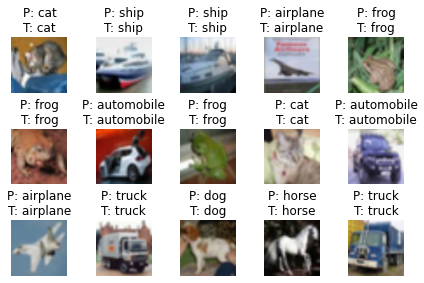

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

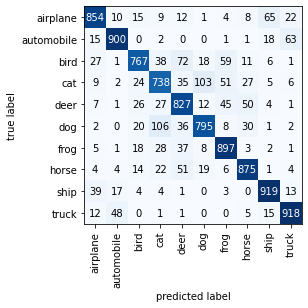

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()